In [48]:
# import python libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # visualizing data
%matplotlib inline
import seaborn as sns
import sqlite3 as sql

### Load CSV into SQLite (in-memory DB)

In [49]:
# Helper: run SQL and see a nice dataframe
def q(sql, params=None):
    return pd.read_sql_query(sql, conn, params=params or {})

In [50]:
# Create SQLite in-memory DB and load the table
conn = sql.connect(":memory:")
df.to_sql("telco", conn, index=False, if_exists="replace")

# Quick peek
q("SELECT * FROM telco LIMIT 5")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Row counts (total & churned)

In [51]:
q("""
SELECT 
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS churned_customers,
    ROUND(100.0 * SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_pct
FROM telco;
""")

,total_customers,churned_customers,churn_rate_pct
0,7043,1869,26.54


### Churn by gender (small categorical)

In [52]:
q("""
SELECT 
    Gender,
    COUNT(*) AS customers,
    SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS churned,
    ROUND(100.0 * SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_pct
FROM telco
GROUP BY Gender
ORDER BY churn_rate_pct DESC;
""")

,gender,customers,churned,churn_rate_pct
0,Female,3488,939,26.92
1,Male,3555,930,26.16


### Churn by contract type 

In [53]:
q("""
SELECT 
    Contract,
    COUNT(*) AS customers,
    SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS churned,
    ROUND(100.0 * SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate_pct
FROM telco
GROUP BY Contract
ORDER BY churn_rate_pct DESC, customers DESC;
""")

,Contract,customers,churned,churn_rate_pct
0,Month-to-month,3875,1655,42.71
1,One year,1473,166,11.27
2,Two year,1695,48,2.83


## Exploratory Data Analysis (EDA) 

### 1. Load Full Dataset into EDA

In [54]:
#   downloaded file path
df = pd.read_csv(r"C:\Users\aniku\Downloads\archive (4)\Telecom Customers Churn.csv")
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


### 2. Missing values check

In [55]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [56]:
df = df.dropna(subset=["TotalCharges"])

In [57]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 3.Churn Distribution

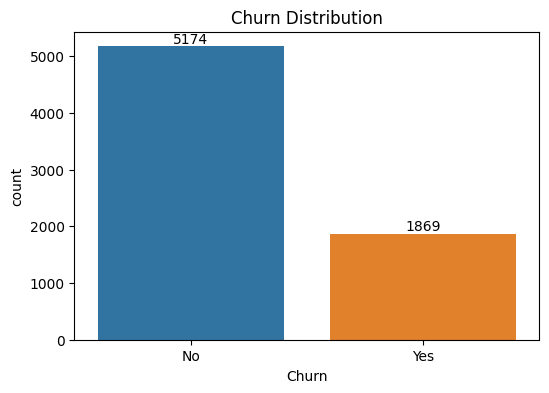

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [58]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df, x="Churn", hue="Churn")

for container in ax.containers:
    ax.bar_label(container)

plt.title("Churn Distribution")
plt.show()

# % churn
df["Churn"].value_counts(normalize=True) * 100

### 4.Churn by Gender

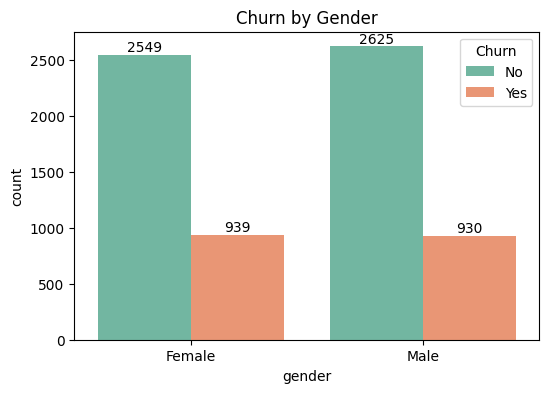

In [59]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x="gender", hue="Churn", palette="Set2")

for container in ax.containers:
    ax.bar_label(container)

plt.title("Churn by Gender")
plt.show()

### 5.Churn by Contract Type

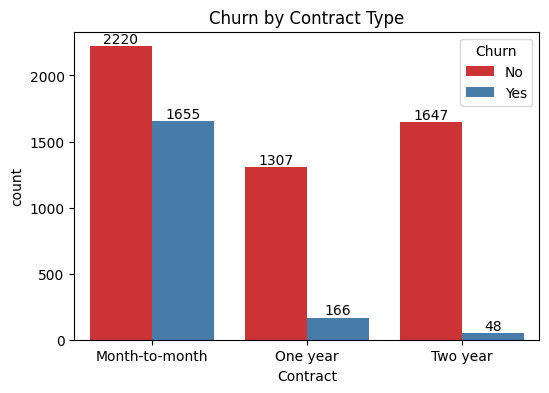

In [60]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df, x="Contract", hue="Churn", palette="Set1")

for container in ax.containers:
    ax.bar_label(container)

plt.title("Churn by Contract Type")
plt.show()

### 6.Churn vs Tenure

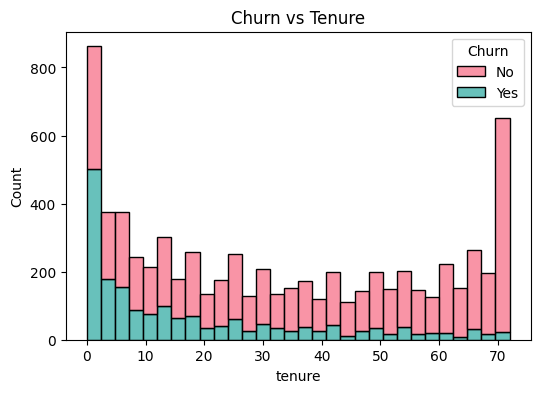

In [61]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, kde=False, palette="husl", multiple="stack")
plt.title("Churn vs Tenure")
plt.show()

### 7.Churn vs Monthly Charges

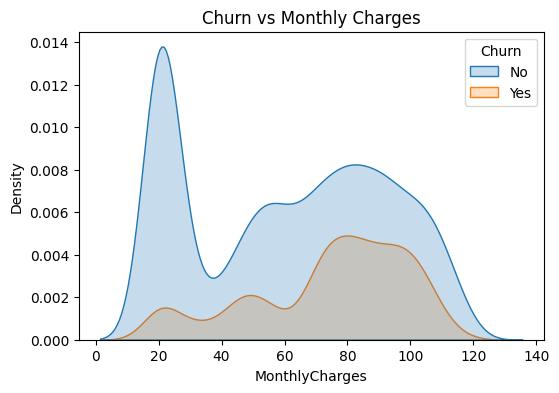

In [62]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True)
plt.title("Churn vs Monthly Charges")
plt.show()


### 8.Churn by Senior Citizen

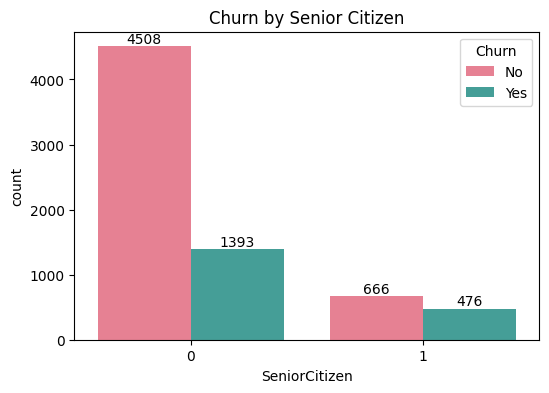

In [63]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df, x="SeniorCitizen", hue="Churn", palette="husl")
for container in ax.containers:
    ax.bar_label(container)

plt.title("Churn by Senior Citizen")
plt.show()

### 9.Churn vs Total Charges

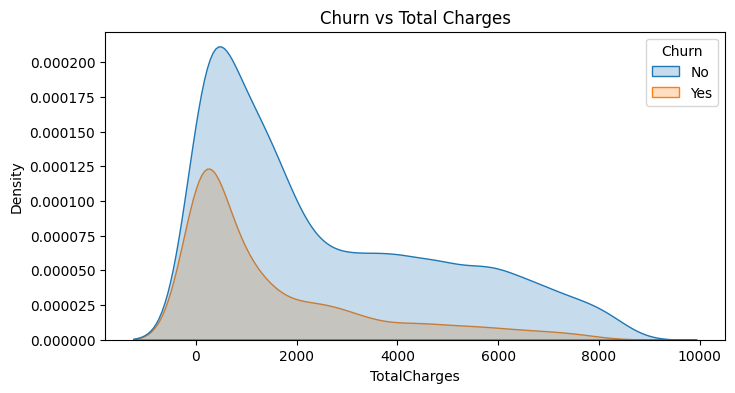

In [66]:
# (Recommended) fix numeric columns that sometimes load as text
for col in ["MonthlyCharges", "TotalCharges"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x="TotalCharges", hue="Churn", fill=True)
plt.title("Churn vs Total Charges")
plt.show()

### 10.Churn by Internet Service

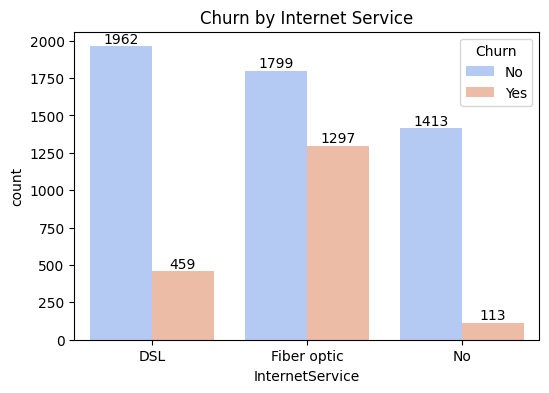

In [67]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df, x="InternetService", hue="Churn", palette="coolwarm")
for container in ax.containers:
    ax.bar_label(container)

plt.title("Churn by Internet Service")
plt.show()

### 11.Churn by Partner and Churn by Dependents

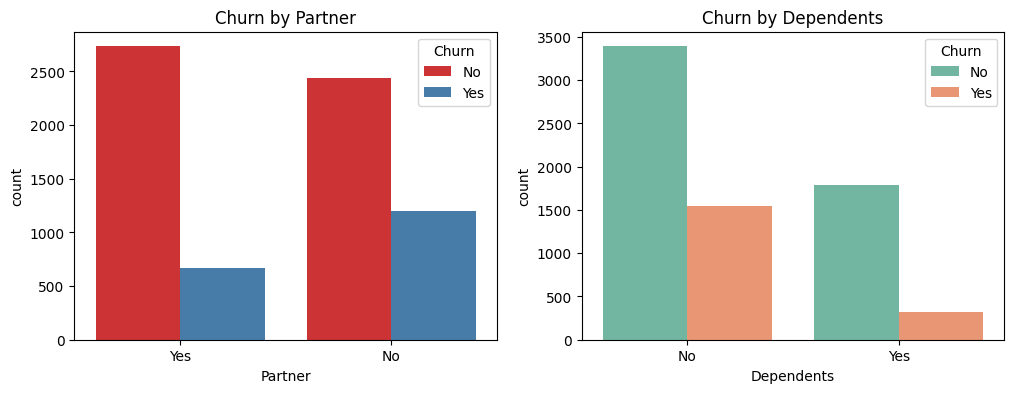

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=df, x="Partner", hue="Churn", palette="Set1", ax=ax[0])
sns.countplot(data=df, x="Dependents", hue="Churn", palette="Set2", ax=ax[1])
ax[0].set_title("Churn by Partner")
ax[1].set_title("Churn by Dependents")
plt.show()